In [2]:
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# **Load data**

In [7]:
INPUT_DIR = '../input/m5-forecasting-accuracy/'
train_df = pd.read_csv('sales_train_evaluation.csv')
price_df = pd.read_csv('sell_prices.csv')
calender_df = pd.read_csv('calendar.csv')

calender_df['date'] = pd.to_datetime(calender_df['date'])

In [9]:
train_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1


In [11]:
calender_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [13]:
price_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


Split *price_df* into 10 dataframes (one dataframe for each store) just to speed up the function *get_item_price* (see below):

In [16]:
price_dfs = {
    'CA_1': price_df[price_df['store_id'] == 'CA_1'],
    'CA_2': price_df[price_df['store_id'] == 'CA_2'],
    'CA_3': price_df[price_df['store_id'] == 'CA_3'],
    'CA_4': price_df[price_df['store_id'] == 'CA_4'],
    'TX_1': price_df[price_df['store_id'] == 'TX_1'],
    'TX_2': price_df[price_df['store_id'] == 'TX_2'],
    'TX_3': price_df[price_df['store_id'] == 'TX_3'],
    'WI_1': price_df[price_df['store_id'] == 'WI_1'],
    'WI_2': price_df[price_df['store_id'] == 'WI_2'],
    'WI_3': price_df[price_df['store_id'] == 'WI_3']
}

Drop the variable which we don't need anymore:

In [18]:
price_df = None

Some functions to prepare a dataframe for one item:

In [20]:
def transform_d_dates_to_dates(d_dates):
    return calender_df.set_index('d').loc[d_dates]['date']


def transform_dates_to_d_dates(dates):
    return calender_df.set_index('date').loc[dates]['d']


def transform_dates_to_wm_yr_wk(dates):
    return calender_df.set_index('date').loc[dates]['wm_yr_wk']


def get_avg_item_n_sold_prev_month(item_id, store_id, dates_df):
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    d_dates_month_ago = transform_dates_to_d_dates(dates_df['date'] - pd.DateOffset(days=28))
    assert d_dates_month_ago.shape == (dates_df.shape[0],)
    
    first_day = int(d_dates_month_ago.iloc[0].split('_')[1]) - 28
    last_day = int(d_dates_month_ago.iloc[-1].split('_')[1])
    assert first_day == 310 and last_day == 1941
    
    tmp = train_df[
        (train_df['item_id'] == item_id) &
        (train_df['store_id'] == store_id)
    ][['d_' + str(i) for i in range(first_day, last_day + 1)]]
    assert tmp.shape == (1, dates_df.shape[0] + 28)
    return tmp.iloc[0].rolling(28).mean().iloc[28:].to_numpy()


def get_item_n_sold_year_ago(item_id, store_id, dates_df):
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    d_dates_year_ago = transform_dates_to_d_dates(dates_df['date'] - pd.DateOffset(years=1))
    assert d_dates_year_ago.shape == (dates_df.shape[0],)
    
    tmp = train_df[
        (train_df['item_id'] == item_id) &
        (train_df['store_id'] == store_id)
    ][d_dates_year_ago]
    assert tmp.shape == (1, dates_df.shape[0])
    return tmp.iloc[0].to_numpy()


def get_item_price(item_id, store_id, dates_df):
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    wm_yr_wk = transform_dates_to_wm_yr_wk(dates_df['date']).to_numpy()
    assert wm_yr_wk.shape == (dates_df.shape[0],)
    
    week_to_price = price_dfs[store_id][
        (price_dfs[store_id]['item_id'] == item_id)
    ].set_index('wm_yr_wk')['sell_price'].to_dict()
    
    price = np.full(dates_df.shape[0], np.nan)
    for i in range(wm_yr_wk.shape[0]):
        week = wm_yr_wk[i]
        if week in week_to_price:
            price[i] = week_to_price[week]
    
    item_price_df = pd.DataFrame(data={'price': price})
    item_price_df = item_price_df.fillna(method='ffill').fillna(method='bfill')

    assert item_price_df['price'].isna().sum() == 0
    assert item_price_df.shape == (dates_df.shape[0], 1)

    # norm_price = item_price_df['price']
    # item_price_df['price'] /= np.linspace(1.00, 1.05, num=item_price_df.shape[0])  # inflation
    norm_price = item_price_df['price'].to_numpy()
    
    assert norm_price.shape == (dates_df.shape[0],)
    return norm_price


def get_is_snap(item_id, store_id, dates_df):
    assert 'FOODS' in item_id
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    if store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4']:
        return dates_df['snap_CA'].to_numpy()
    elif store_id in ['TX_1', 'TX_2', 'TX_3']:
        return dates_df['snap_TX'].to_numpy()
    elif store_id in ['WI_1', 'WI_2', 'WI_3']:
        return dates_df['snap_WI'].to_numpy()

    assert False
    return None
    
    
def get_week_days_features(item_id, store_id, dates_df):
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    return pd.DataFrame(
        index=dates_df['d'],
        data={
            'is_Monday': (dates_df['weekday'] == 'Monday').astype(int).to_numpy(),
            'is_Tuesday': (dates_df['weekday'] == 'Tuesday').astype(int).to_numpy(),
            'is_Wednesday': (dates_df['weekday'] == 'Wednesday').astype(int).to_numpy(),
            'is_Thursday': (dates_df['weekday'] == 'Thursday').astype(int).to_numpy(),
            'is_Friday': (dates_df['weekday'] == 'Friday').astype(int).to_numpy(),
            'is_Saturday': (dates_df['weekday'] == 'Saturday').astype(int).to_numpy()
        }
    )
    
    
def get_event_features(item_id, store_id, dates_df):
    assert len(item_id.split('_')) == 3
    assert store_id in ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
    assert dates_df.shape == (1604, 14)
    
    events_df = dates_df[['date', 'd', 'event_type_1', 'event_type_2']].copy()
    events_df['tomorrow_event_type_1'] = events_df['event_type_1'].shift(periods=-1)
    events_df['tomorrow_event_type_2'] = events_df['event_type_2'].shift(periods=-1)
    
    return pd.DataFrame(
        index=events_df['d'],
        data={
            'is_today_religious': (
                (events_df['event_type_1'] == 'Religious') |
                (events_df['event_type_2'] == 'Religious')
            ).astype(int).to_numpy(),
            'is_today_national': (
                (events_df['event_type_1'] == 'National') |
                (events_df['event_type_2'] == 'National')
            ).astype(int).to_numpy(),
            'is_today_cultural': (
                (events_df['event_type_1'] == 'Cultural') |
                (events_df['event_type_2'] == 'Cultural')
            ).astype(int).to_numpy(),
            'is_today_sporting': (
                (events_df['event_type_1'] == 'Sporting') |
                (events_df['event_type_2'] == 'Sporting')
            ).astype(int).to_numpy(),
            'is_tomorrow_religious': (
                (events_df['tomorrow_event_type_1'] == 'Religious') |
                (events_df['tomorrow_event_type_2'] == 'Religious')
            ).astype(int).to_numpy(),
            'is_tomorrow_national': (
                (events_df['tomorrow_event_type_1'] == 'National') |
                (events_df['tomorrow_event_type_2'] == 'National')
            ).astype(int).to_numpy(),
            'is_tomorrow_cultural': (
                (events_df['tomorrow_event_type_1'] == 'Cultural') |
                (events_df['tomorrow_event_type_2'] == 'Cultural')
            ).astype(int).to_numpy(),
            'is_tomorrow_sporting': (
                (events_df['tomorrow_event_type_1'] == 'Sporting') |
                (events_df['tomorrow_event_type_2'] == 'Sporting')
            ).astype(int).to_numpy()
        }
    )


def get_item_X_y(item, is_debug):
    assert len(item.split('_')) == 5
    
    dates_df = calender_df.iloc[365:]
    
    item_parts = item.split('_')
    item_id = item_parts[0] + '_' + item_parts[1] + '_' + item_parts[2]
    store_id = item_parts[3] + '_' + item_parts[4]
    
    df = pd.DataFrame(
        index=dates_df['d'].to_numpy(),
        data={
            'avg_item_n_sold_prev_month': get_avg_item_n_sold_prev_month(item_id, store_id, dates_df),
            'item_n_sold_year_ago': get_item_n_sold_year_ago(item_id, store_id, dates_df),
            'price': get_item_price(item_id, store_id, dates_df)
        }
    )
    
    if 'FOODS' in item:
        df['is_snap'] = get_is_snap(item_id, store_id, dates_df)
        
    df = pd.concat([
        df,
        get_week_days_features(item_id, store_id, dates_df),
        get_event_features(item_id, store_id, dates_df)
    ], axis=1)
    assert df.isna().sum().sum() == 0
    
    features_to_drop = []
    for feature in df.columns:
        if len(df[feature].unique()) <= 1:
            features_to_drop.append(feature)
    df = df.drop(features_to_drop, axis=1)
    if is_debug:
        print('Features', features_to_drop, 'have been dropped')
    
    target = train_df[
        train_df['id'] == item + '_evaluation'
    ][
        ['d_' + str(i) for i in range(366, 1942)]
    ].to_numpy()[0]
    assert target.shape == (1576,)
    target = np.concatenate([target, np.full(28, np.nan)])
    df['target'] = target

    return df

Functions to train a model (one model for each item):

In [22]:
def plot_feature_importances(model, features):
    assert len(model.coef_) == len(features)
    plt.figure(figsize=(12, 4))
    plt.title('FEATURE IMPORTANCES')
    sns.barplot(x=model.coef_, y=features)
    
    
def plot_public_test(y_true, y_pred):
    assert y_true.shape == y_pred.shape == (28,)
    plt.figure(figsize=(14, 3))
    plt.title('PUBLIC TEST')
    plt.plot([i for i in range(1, 29)], y_true, label='true')
    plt.plot([i for i in range(1, 29)], y_pred, label='pred')
    plt.legend()


def train_item_model(item, is_debug):
    df = get_item_X_y(item, is_debug)
    assert df.shape[0] == 1604

    X = df.drop(['target'], axis=1)
    y = df['target']
    
    X_train = X.loc[['d_' + str(i) for i in range(366, 1914)]]  # train
    y_train = y.loc[['d_' + str(i) for i in range(366, 1914)]]  # train
    assert X_train.shape[0] == y_train.shape[0] == 1548
    
    X_valid = X.loc[['d_' + str(i) for i in range(1914, 1942)]]  # public test
    y_valid = y.loc[['d_' + str(i) for i in range(1914, 1942)]]  # public test
    X_test = X.loc[['d_' + str(i) for i in range(1942, 1970)]]  # private test
    assert X_valid.shape[0] == y_valid.shape[0] == X_test.shape[0] == 28
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # train
    X_valid = scaler.transform(X_valid)  # public test
    X_test = scaler.transform(X_test)  # private test
    
    model = Ridge()
    model.fit(X_train, y_train)
    
    y_valid_pred = model.predict(X_valid)
    y_valid_pred[y_valid_pred < 0] = 0
    y_valid_pred[y_valid_pred > y.max()] = y.max()
    
    y_test_pred = model.predict(X_test)
    y_test_pred[y_test_pred < 0] = 0
    y_test_pred[y_test_pred > y.max()] = y.max()
    
    if is_debug:
        plot_feature_importances(model, X.columns)
        plot_public_test(y_valid, y_valid_pred)
        print('PUBLIC TEST: mean_absolute_error =', mean_absolute_error(y_valid, y_valid_pred))
    
    return y_valid_pred, y_test_pred

Let's take a look at one random dataframe:

In [24]:
get_item_X_y('HOBBIES_1_004_CA_1', is_debug=True)

Features [] have been dropped


/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_22526/3384046350.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_price_df = item_price_df.fillna(method='ffill').fillna(method='bfill')


,avg_item_n_sold_prev_month,item_n_sold_year_ago,price,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_today_religious,is_today_national,is_today_cultural,is_today_sporting,is_tomorrow_religious,is_tomorrow_national,is_tomorrow_cultural,is_tomorrow_sporting,target
d_366,1.607143,0,4.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
d_367,1.500000,0,4.34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
d_368,1.428571,0,4.34,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0
d_369,1.428571,0,4.34,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0
d_370,1.357143,0,4.34,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1965,1.821429,0,4.64,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN
d_1966,1.892857,1,4.64,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
d_1967,1.785714,0,4.64,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
d_1968,1.607143,2,4.64,0,0,0,0,0,1,0,0,0,0,0,0,1,1,NaN


# **Model for one random item**

Features [] have been dropped
PUBLIC TEST: mean_absolute_error = 1.3565196165608422


/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_22526/3384046350.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_price_df = item_price_df.fillna(method='ffill').fillna(method='bfill')


(array([1.5593449 , 1.40635625, 1.24243174, 1.73501661, 1.38037153,
        2.72514741, 3.52053359, 1.80019781, 1.67325717, 1.58965714,
        1.1545135 , 1.73067222, 3.27498294, 3.1243609 , 2.07040035,
        1.56750553, 1.42962904, 1.75620343, 1.74369623, 3.00259998,
        3.60883476, 1.90438987, 1.61143875, 1.40844223, 1.65201137,
        1.64766698, 2.94564276, 3.58764794]),
 array([1.67325935, 1.310327  , 1.3693702 , 1.76106462, 1.80065345,
        3.01562399, 3.61447528, 1.83259303, 2.18431263, 0.89988495,
        1.61594565, 1.69976301, 3.22556769, 3.63974397, 1.23509223,
        1.64521485, 1.32543699, 1.63412616, 1.80065345, 2.95866676,
        3.37770424, 1.39333442, 1.99711533, 1.21638373, 1.67805938,
        1.59557095, 2.82494247, 2.84083904]))

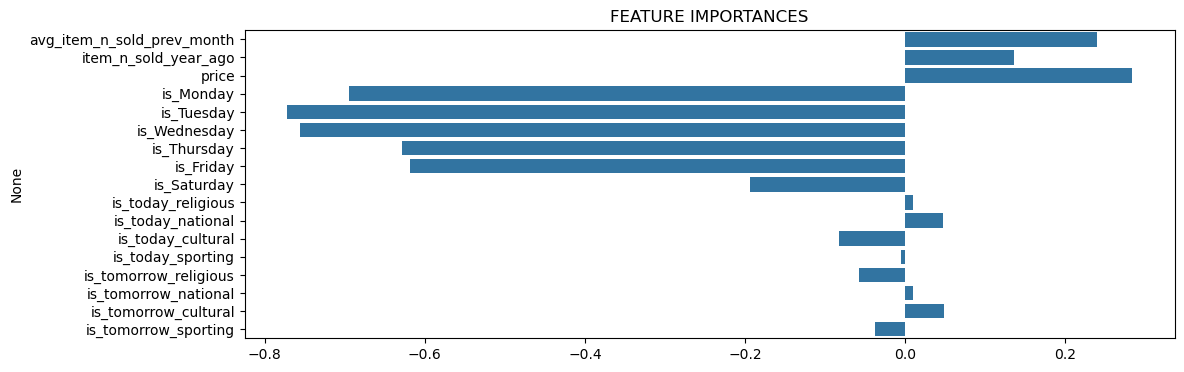

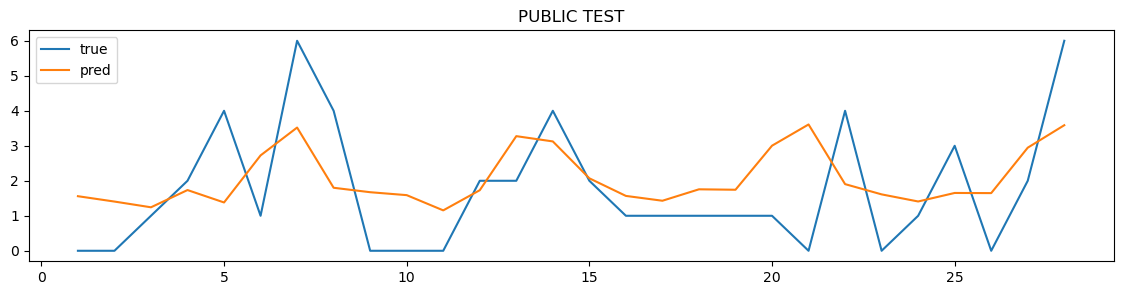

In [26]:
train_item_model('HOBBIES_1_004_CA_1', is_debug=True)

# **Models for all items**

In [32]:
submission = pd.read_csv('sample_submission.csv')

In [34]:
for i in tqdm.tqdm(range(train_df.shape[0])):
    item = train_df.iloc[i]['item_id'] + '_' + train_df.iloc[i]['store_id']
    public_test_y, private_test_y = train_item_model(item, is_debug=False)

    submission.loc[
        submission[submission['id'] == item + '_validation'].index,
        ['F' + str(i) for i in range(1, 29)]
    ] = public_test_y

    submission.loc[
        submission[submission['id'] == item + '_evaluation'].index,
        ['F' + str(i) for i in range(1, 29)]
    ] = private_test_y

  0%|                                                 | 0/30490 [00:00<?, ?it/s]/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_22526/3384046350.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_price_df = item_price_df.fillna(method='ffill').fillna(method='bfill')
/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_22526/2763963311.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7736251249095889' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[
/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_22526/2763963311.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7206880927418684' has dtype incompatible with int64, please explicitly cas

In [35]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.773625,0.720688,0.653273,0.574342,0.713840,0.750954,0.624759,0.658445,0.881988,...,0.656843,0.854121,0.715783,0.612326,0.709178,0.561113,0.597362,0.645333,0.819591,0.715783
1,HOBBIES_1_002_CA_1_validation,0.189387,0.224381,0.335260,0.232172,0.284105,0.471501,0.367883,0.166304,0.345457,...,0.395726,0.306676,0.212513,0.150916,0.330069,0.160324,0.633872,0.243873,0.435446,0.189431
2,HOBBIES_1_003_CA_1_validation,0.325050,0.336779,0.335092,0.354129,0.330038,0.347746,0.275582,0.216169,0.168704,...,0.291285,0.430229,0.322118,0.309543,0.318104,0.356935,0.354129,0.403334,0.523604,0.396818
3,HOBBIES_1_004_CA_1_validation,1.559345,1.406356,1.242432,1.735017,1.380372,2.725147,3.520534,1.800198,1.673257,...,1.743696,3.002600,3.608835,1.904390,1.611439,1.408442,1.652011,1.647667,2.945643,3.587648
4,HOBBIES_1_005_CA_1_validation,0.858487,0.801029,0.980502,1.013770,1.097163,1.680194,1.676922,0.952766,0.958026,...,1.025010,1.553273,1.488326,0.820537,0.815808,0.907796,0.931077,1.001840,1.564858,1.557838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.082267,0.014588,0.073149,0.101205,0.183526,0.183663,0.414893,0.163599,0.145600,...,0.244450,0.322989,0.470329,0.285346,0.316376,0.395245,0.302305,0.325681,0.626113,0.616566
60976,FOODS_3_824_WI_3_evaluation,0.266447,0.214580,0.287536,0.288101,0.241014,0.224100,0.308510,0.068486,0.192702,...,0.131627,0.332487,0.452934,0.222692,0.344843,0.395922,0.200591,0.153505,0.190130,0.389728
60977,FOODS_3_825_WI_3_evaluation,0.890586,0.658798,0.706692,0.721279,0.765702,0.908665,0.930750,0.640711,0.677016,...,0.656396,1.238941,1.308721,0.817715,1.061945,1.101231,0.621583,0.674614,0.574461,0.620406
60978,FOODS_3_826_WI_3_evaluation,0.718315,0.864795,0.731900,0.781833,0.795356,0.918836,1.136823,0.816103,0.944782,...,0.822018,1.101812,1.251729,1.038265,1.421045,1.261488,1.155108,1.061981,1.414959,1.173079


In [37]:
submission.to_csv('submission.csv', index=False)